In [1]:
%cd supervised
%load_ext autoreload
%autoreload 2

import data
import train
import evaluate
import torch

/home/maarten/Documents/masterthesis/supervised


# Dataset analysis

In [ ]:
import glob
from lxml import etree

positives = []
negatives = []
for path in glob.glob('../training_data/*.xml'):
    with open(path, 'r') as f:
        xml = etree.fromstring(f.read().encode('utf-8'))
    pos = len(xml.xpath('/pdf2xml/page/text[@is-speech="true"]'))
    neg = len(xml.xpath('/pdf2xml/page/text[@is-speech="false"]'))
    positives.append(pos)
    negatives.append(neg)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

sns.distplot(positives, axlabel='positive samples per file')
fig = plt.gcf()
plt.show()
fig.savefig('distribution.pdf')

print(tabulate([['Positives samples', sum(positives)],
                ['Negative samples', sum(negatives)]]))

# Training and evaluation

In [2]:
num_clusters = 5

files = [f'../clusterlabeled-{num_clusters}/18{i:03d}.xml' for i in range(1, 20) if i not in [8, 12]]
test_files = [f'../clusterlabeled-{num_clusters}/18{i:03d}.xml' for i in [21, 22, 23, 24]]
source_dataset = data.GermanDataset(files, num_clusters, 10000, 10000, 3, 1)

 36%|███▌      | 3550/10000 [00:22<00:41, 156.03it/s]


Retrieved 10000 positive samples, 10000 negative samples.


In [ ]:
test_dataset = data.GermanDataset(test_files, num_clusters, 10000, 10000, 3, 1, vocab=source_dataset.vocab)

In [3]:
small_dataset = source_dataset.split((200, 200))
medium_dataset = source_dataset.split((600, 600))
large_dataset = source_dataset.split((1200, 1200))

In [4]:
params = train.CNNParams(
    embed_size=300,
    dropout=0.50,
    epochs=50,
    num_filters=100,
    kernel_size=3,
    num_layers=1
)
optimizer = lambda p: torch.optim.Adadelta(p, weight_decay=1e-4)

## 10-fold cross validation on the small dataset

In [61]:
k = 10
folds = small_dataset.kfold(k=k)
f1_scores_plain = []
aoc_scores_plain = []
f1_scores_cluster = []
aoc_scores_cluster = []
for i in range(k):
    torch.cuda.empty_cache()
    training_folds = [folds[j] for j in range(k) if j != i]
    train_set = data.ConcatDataset(training_folds)
    test_set = folds[i]

    plain_model, plain_losses = train.setup_and_train(params, with_labels=False, dataset=train_set,
                                                      epochs=params.epochs, batch_size=50, optim_fn=optimizer)
    cluster_model, cluster_losses = train.setup_and_train(params, with_labels=False, dataset=train_set,
                                                          epochs=params.epochs, batch_size=50, optim_fn=optimizer)
    
    plain_scores, cluster_scores, fig = evaluate.compare(plain_model, cluster_model, test_set)
    f1_scores_plain.append(plain_scores['F1'])
    aoc_scores_plain.append(plain_scores['AoC'])
    f1_scores_cluster.append(cluster_scores['F1'])
    aoc_scores_cluster.append(cluster_scores['AoC'])

Training: 100%|██████████| 50/50 [00:16<00:00,  2.95it/s, loss=0.429, Δloss=0.0796] 


F1 score
              mean     stddev
--------  --------  ---------
plain     0.816051  0.175257
clusters  0.947793  0.0762222

Area under precision/recall curve
              mean     stddev
--------  --------  ---------
plain     0.836736  0.114367
clusters  0.918082  0.0948271

T-test probability that the distributions are the same: 0.11781765208605635


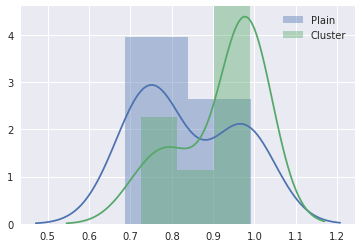

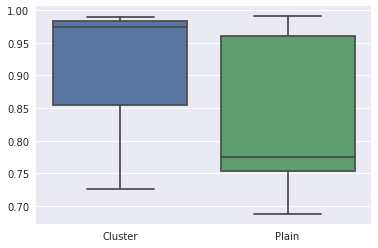

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from tabulate import tabulate

print('F1 score')
print(tabulate([['plain', np.mean(f1_scores_plain), np.std(f1_scores_plain)],
                ['clusters', np.mean(f1_scores_cluster), np.std(f1_scores_cluster)]],
               headers=['', 'mean', 'stddev']))

print()
print('Area under precision/recall curve')
print(tabulate([['plain', np.mean(aoc_scores_plain), np.std(aoc_scores_plain)],
                ['clusters', np.mean(aoc_scores_cluster), np.std(aoc_scores_cluster)]],
               headers=['', 'mean', 'stddev']))

print()
p = scipy.stats.ttest_ind(aoc_scores_plain, aoc_scores_cluster)
print(f'T-test probability that the distributions are the same: {p.pvalue}')

df = pd.DataFrame({'Plain': aoc_scores_plain, 'Cluster': aoc_scores_cluster})

sns.distplot(aoc_scores_plain, label='Plain')
sns.distplot(aoc_scores_cluster, label='Cluster')

plt.legend()

plt.figure()
sns.boxplot(data=df);

## 10-fold cross validation on the medium dataset

Training: 100%|██████████| 50/50 [00:45<00:00,  1.10it/s, loss=0.352, Δloss=0.0216]   


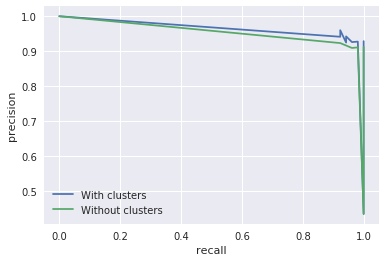

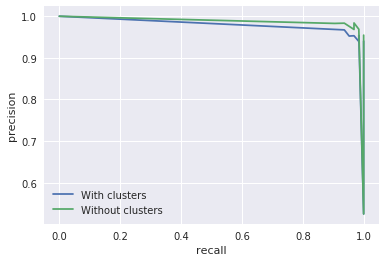

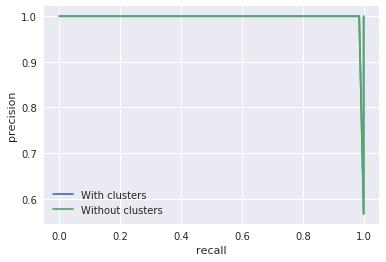

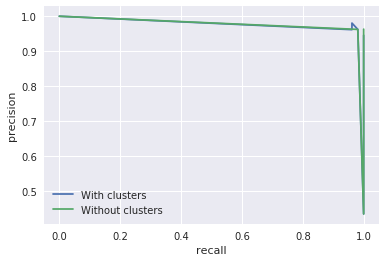

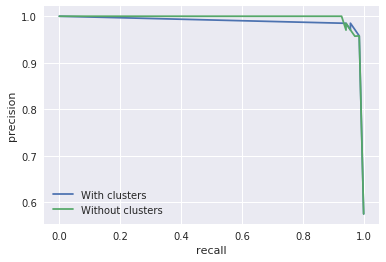

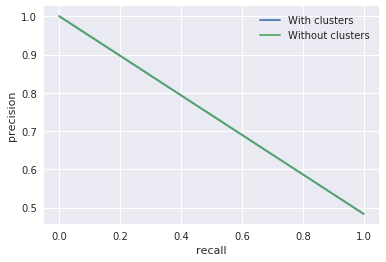

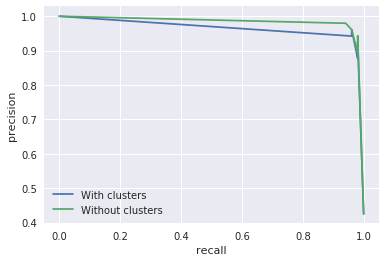

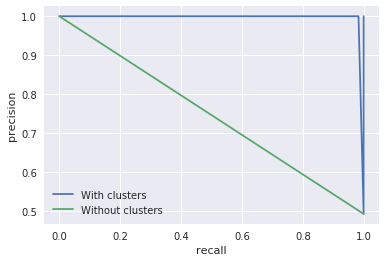

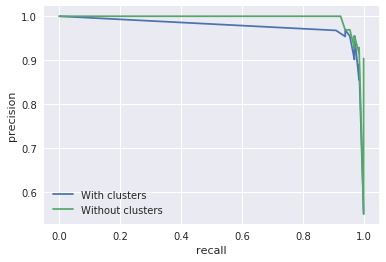

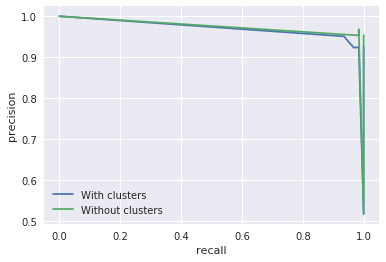

In [6]:
k = 10
folds = medium_dataset.kfold(k=k)
f1_scores_plain = []
aoc_scores_plain = []
f1_scores_cluster = []
aoc_scores_cluster = []
for i in range(k):
    torch.cuda.empty_cache()
    training_folds = [folds[j] for j in range(k) if j != i]
    train_set = data.ConcatDataset(training_folds)
    test_set = folds[i]

    plain_model, plain_losses = train.setup_and_train(params, with_labels=False, dataset=train_set,
                                                      epochs=params.epochs, batch_size=50, optim_fn=optimizer)
    cluster_model, cluster_losses = train.setup_and_train(params, with_labels=False, dataset=train_set,
                                                          epochs=params.epochs, batch_size=50, optim_fn=optimizer)
    
    plain_scores, cluster_scores, fig = evaluate.compare(plain_model, cluster_model, test_set)
    f1_scores_plain.append(plain_scores['F1'])
    aoc_scores_plain.append(plain_scores['AoC'])
    f1_scores_cluster.append(cluster_scores['F1'])
    aoc_scores_cluster.append(cluster_scores['AoC'])

F1 score
              mean    stddev
--------  --------  --------
plain     0.909466  0.127577
clusters  0.94117   0.097513

Area under precision/recall curve
              mean     stddev
--------  --------  ---------
plain     0.934321  0.0960708
clusters  0.954918  0.0719725

T-test probability that the distributions are the same: 0.6129981504974173


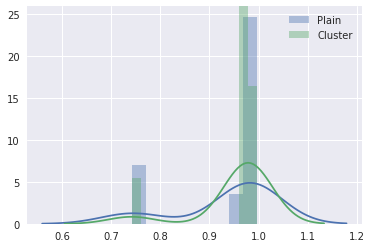

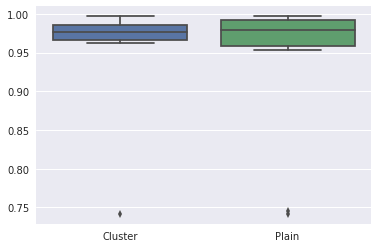

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from tabulate import tabulate

print('F1 score')
print(tabulate([['plain', np.mean(f1_scores_plain), np.std(f1_scores_plain)],
                ['clusters', np.mean(f1_scores_cluster), np.std(f1_scores_cluster)]],
               headers=['', 'mean', 'stddev']))

print()
print('Area under precision/recall curve')
print(tabulate([['plain', np.mean(aoc_scores_plain), np.std(aoc_scores_plain)],
                ['clusters', np.mean(aoc_scores_cluster), np.std(aoc_scores_cluster)]],
               headers=['', 'mean', 'stddev']))

print()
p = scipy.stats.ttest_ind(aoc_scores_plain, aoc_scores_cluster)
print(f'T-test probability that the distributions are the same: {p.pvalue}')

df = pd.DataFrame({'Plain': aoc_scores_plain, 'Cluster': aoc_scores_cluster})

sns.distplot(aoc_scores_plain, label='Plain')
sns.distplot(aoc_scores_cluster, label='Cluster')

plt.legend()

plt.figure()
sns.boxplot(data=df);

In [ ]:
from collections import namedtuple
ClusterTuple = namedtuple('Clustertuple', ['with_clusters', 'without_clusters'])
models = {}
training_losses = {}
for name, dataset in [('100 samples', tiny_dataset), ('400 samples', small_dataset),
                      ('2000 samples', medium_dataset)]:#, ('4500 samples', large_dataset)]:
    params = train.CNNParams(
        embed_size=300,
        dropout=0.50,
        epochs=30,
        num_filters=100,
        kernel_size=3,
        num_layers=1
    )

    optimizer = lambda p: torch.optim.Adadelta(p, weight_decay=1e-4)
    model, losses = train.setup_and_train(params, with_labels=False, dataset=dataset,
                                          epochs=params.epochs, batch_size=32, optim_fn=optimizer)
    cluster_model, cluster_losses = train.setup_and_train(params, with_labels=True,
                                                          dataset=dataset, epochs=params.epochs,
                                                          batch_size=32, optim_fn=optimizer)
    
    models[name] = ClusterTuple(cluster_model, model)
    training_losses[name] = ClusterTuple(cluster_losses, losses)

In [ ]:
for name, loss in training_losses.items():
    evaluate.plot({'with clusters': loss.with_clusters, 'without clusters': loss.without_clusters},
                  'epoch', 'loss', False, f'Loss per epoch, {name}')
    evaluate.plt.figure();

In [ ]:
from tabulate import tabulate
for name, model in models.items():
    print(name)
    print('----')
    
    nocluster_p, nocluster_r = evaluate.precision_recall_values(model.without_clusters, data.get_iterator(test_dataset, [40]))
    cluster_p, cluster_r = evaluate.precision_recall_values(model.with_clusters, data.get_iterator(test_dataset, [40]));
    evaluate.plot({'With clusters': (cluster_r, cluster_p), 'Without clusters': (nocluster_r, nocluster_p)},
              'recall', 'precision', title=f'Precision/recall curve, {name}')
    evaluate.plt.figure()

    table = [['With clusters', evaluate.average_precision(cluster_p, cluster_r), evaluate.max_f1(cluster_p, cluster_r)],
             ['Without clusters', evaluate.average_precision(nocluster_p, nocluster_r), evaluate.max_f1(nocluster_p, nocluster_r)]]
    print(tabulate(table, headers=['', 'Maximum F1 score', 'Average precision']))
    print()

In [ ]:
del source_dataset

# Older data

This section tests the trained models on a number of files from the older wahlperiods.

In [ ]:
import os
files = os.listdir(f'../testing_data_older-{num_clusters}/')
paths = [f'../testing_data_older-{num_clusters}/' + f for f in files]
old_data = data.GermanDataset(paths, num_clusters, 10000, 10000, 3, 0, vocab=large_dataset.vocab)

In [ ]:
model = models["2400 samples"]
old_nocluster_p, old_nocluster_r = evaluate.precision_recall_values(model.without_clusters, data.get_iterator(old_data, [40]))
old_cluster_p, old_cluster_r = evaluate.precision_recall_values(model.with_clusters, data.get_iterator(old_data, [40]));

table = [['With clusters', evaluate.average_precision(old_cluster_p, old_cluster_r),
          evaluate.max_f1(old_cluster_p, old_cluster_r)],
         ['Without clusters', evaluate.average_precision(old_nocluster_p, old_nocluster_r),
          evaluate.max_f1(old_nocluster_p, old_nocluster_r)]]
print(tabulate(table, headers=['', 'Maximum F1 score', 'Average precision']))
evaluate.plot({'With clusters': (old_cluster_r, old_cluster_p), 'Without clusters': (old_nocluster_r, old_nocluster_p)},
              'recall', 'precision', title='Precision/recall curve')

# BoW baseline

In [ ]:
import nltk
files = [f'../clusterlabeled-{num_clusters}/18{i:03d}.xml' for i in range(1, 20) if i not in [8, 12]]
test_files = [f'../clusterlabeled-{num_clusters}/18{i:03d}.xml' for i in [21, 22, 23]]
bow_dataset = data.GermanDataset(files, num_clusters, 800, 1600, 3, 0, bag_of_words=True)
bow_test = data.GermanDataset(test_files, num_clusters, 10000, 10000, 3, 0, vocab=bow_dataset.vocab,
                                  bag_of_words=True)

In [ ]:
small_vocab = medium_dataset.vocab.token_to_idx
small_vocab['vvvvvv'] = 0

In [ ]:
print('Unigrams:')
svm, vectorizer = train.train_BoW(bow_dataset, small_vocab)
print(evaluate.evaluate_bow(svm, vectorizer, bow_test))

print('Bigrams:')
svm, vectorizer = train.train_BoW(bow_dataset, small_vocab, ngram_range=(1, 2))
print(evaluate.evaluate_bow(svm, vectorizer, bow_test))